# Vietnamese NLP example
Created on: 12 Septembre 2021.

In [1]:
import fastai
fastai.__version__

'2.4'

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text.all import *
bs = 144
torch.cuda.set_device(0)

# data_path = Config.data_path()   # for fastai v1
# data_path = Path(os.getenv('FASTAI_HOME', '~/.fastai')).expanduser()  #  for fastai v2. 
# data_path = Path("./")
data_path = Config.config_path
data_path

Path('/home/wabinab/.fastai')

This will create a `viwiki` folder, containing `viwiki` text file with wikipedia contents. (For other languages, replace `vi` with appropriate code from [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias)). 

In [3]:
lang = "vi"
# lang = "zh"

name = f"{lang}wiki"
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f"{lang}_wt_bwd", f"{lang}_wt_vocab_bwd"]

## Vietnamese Wikipedia model
### Download data

It was noticed the new `wikiextractor` doesn't have several of the functions that used to have. It might result in stub files also being downloaded. 

In [4]:
from nlputils import split_wiki, get_wiki
# get_wiki(path, lang)
# path.ls()

Indeed one already checks that it doesn't, so one have to do the thing manually after it extracts. 

In [5]:
# !head -n4 {path}/{name}

If we use curly braces, it is an actual python variable that could be use in IPython bash. Looking at the first line, it always start with `<doc...>` and it always contains the title inside this html marking. So we can split wiki into multiple text files. 

In [6]:
dest = split_wiki(path, lang)
dest.ls()[:5]

/home/wabinab/.fastai/viwiki/docs already exists; not splitting.


(#5) [Path('/home/wabinab/.fastai/viwiki/docs/Quỹ đầu tư.txt'),Path('/home/wabinab/.fastai/viwiki/docs/Voltaire.txt'),Path('/home/wabinab/.fastai/viwiki/docs/Dãy núi Ba Vì.txt'),Path('/home/wabinab/.fastai/viwiki/docs/Pakistan.txt'),Path('/home/wabinab/.fastai/viwiki/docs/Càn lăng.txt')]

# Breakpoint
For continuation of this file, we would do this on Kaggle for training purposes. 

In [7]:
get_vi = partial(get_text_files, folders=["docs"])

dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True, backwards=True),
    get_items=get_vi, splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=bs, seq_len=80, num_workers=os.cpu_count(), 
             backwards=True)  # not sure if need pass here or not? 

dls_lm.show_batch(max_n=2)

,text,text_
0,"> doc / < \n\n tvb xxup niên thường thưởng giải xxmaj | "" ; daa520 xxup # : style=""background "" colspan=""3 ! \n . ngoài kết liên xxmaj \n . bè bạn là chỉ họ rằng cho và này tin thông nhận phủ tiếng lên đã huyên xxmaj tuyên xxmaj nhưng , lạc xxmaj thiên xxmaj cổ xxup và lương xxmaj gia xxmaj la xxmaj là phim bộ nhiều trong cô với chung đóng thường viên diễn nam hai","doc / < \n\n tvb xxup niên thường thưởng giải xxmaj | "" ; daa520 xxup # : style=""background "" colspan=""3 ! \n . ngoài kết liên xxmaj \n . bè bạn là chỉ họ rằng cho và này tin thông nhận phủ tiếng lên đã huyên xxmaj tuyên xxmaj nhưng , lạc xxmaj thiên xxmaj cổ xxup và lương xxmaj gia xxmaj la xxmaj là phim bộ nhiều trong cô với chung đóng thường viên diễn nam hai với"
1,"năm vào thêm triển phát được và , 1997 năm vào hành phát , leaf xxmaj của "" heart xxmaj to "" novel visual từ yếu chủ hưởng ảnh chịu đầu ban này thức công xxmaj . phúc hạnh đầy xúc cảm bậc khung những của hợp tái sự là ) luôn luôn phải không ( cùng cuối , mát mất và cắt chia sự của đau nỗi là đến kế , hước hài lẫn xen ấm nồng mạn lãng","vào thêm triển phát được và , 1997 năm vào hành phát , leaf xxmaj của "" heart xxmaj to "" novel visual từ yếu chủ hưởng ảnh chịu đầu ban này thức công xxmaj . phúc hạnh đầy xúc cảm bậc khung những của hợp tái sự là ) luôn luôn phải không ( cùng cuối , mát mất và cắt chia sự của đau nỗi là đến kế , hước hài lẫn xen ấm nồng mạn lãng khắc"


/home/wabinab/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=tensor(0.0002))

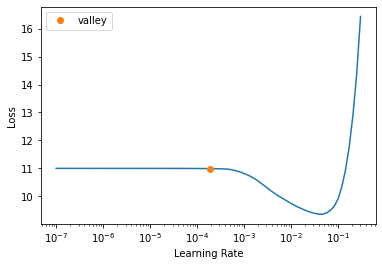

In [8]:
torch.cuda.empty_cache()
learn = language_model_learner(dls_lm, AWD_LSTM, pretrained=False, drop_mult=0.3,
                        metrics=[accuracy, Perplexity()]).to_fp16()
lr = 3e-3
lr *= bs/48  # scale learning rate by batch size.
learn.lr_find()  # For your curiosity. 

In [9]:
learn.unfreeze()
learn.fit_one_cycle(10, lr)  # make sure change this, this is just testing. 

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.686874,4.032805,0.346884,56.418941,14:47
1,3.398120,3.538973,0.379564,34.431553,14:04
2,3.359316,3.430507,0.390554,30.892307,14:04
3,3.241295,3.350292,0.399472,28.511070,14:22
4,3.151138,3.269285,0.408591,26.292526,14:00
5,3.118259,3.191454,0.418093,24.323778,13:59
6,3.046379,3.112161,0.427294,22.469542,13:59
7,2.971502,3.037523,0.436382,20.853531,14:02
8,2.904907,2.988927,0.443223,19.864359,14:03
9,2.937794,2.976365,0.445052,19.616373,14:02


In [10]:
save_path = Path(".")  # also change this with kaggle

mdl_path = path/"models"
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns[0], with_opt=False)
save_pickle(mdl_path/(lm_fns[1] + ".pkl"), learn.dls.vocab)

We want to find baseline (someone using that to predict sentiment). Sentiment analysis dataset in Vietnamese, and someone whom would use that dataset to predict sentiment. It's difficult especially when in another language. Find for competitions if we need from the internet, and use Google Translate. We can find what score it displays, find for forum, e.g. 

## Vietnamese sentiment analysis

In [11]:
train_df = pd.read_csv(path/"sentiment/train.csv")
train_df.loc[pd.isna(train_df.comment), "comment"] = "NA"
train_df.head()

,id,comment,label
0,train_000000,Dung dc sp tot cam on \nshop Đóng gói sản phẩm rất đẹp và chắc chắn Chất lượng sản phẩm tuyệt vời,0
1,train_000001,Chất lượng sản phẩm tuyệt vời . Son mịn nhưng khi đánh lên không như màu trên ảnh,0
2,train_000002,Chất lượng sản phẩm tuyệt vời nhưng k có hộp k có dây giày đen k có tất,0
3,train_000003,:(( Mình hơi thất vọng 1 chút vì mình đã kỳ vọng cuốn sách khá nhiều hi vọng nó sẽ nói về việc học tập của cách sinh viên trường Harvard ra sao những nỗ lực của họ như thế nào 4h sáng? tại sao họ lại phải thức dậy vào thời khắc đấy? sau đó là cả một câu chuyện ra sao. Cái mình thực sự cần ở đây là câu chuyện ẩn dấu trong đó để tự bản thân mỗi người cảm nhận và đi sâu vào lòng người hơn. Còn cuốn sách này chỉ đơn thuần là cuốn sách dạy kĩ năng mà hầu như sách nào cũng đã có. BUồn...,1
4,train_000004,Lần trước mình mua áo gió màu hồng rất ok mà đợt này lại giao 2 cái áo gió chất khác như vải mưa ý :((,1


In [12]:
test_df = pd.read_csv(path/"sentiment/test.csv")
test_df.loc[pd.isna(test_df.comment), "comment"] = "NA"
test_df["label"] = 0  # Not sure why for this but it is included. 
test_df.head()

,id,comment,label
0,test_000000,Chưa dùng thử nên chưa biết,0
1,test_000001,Không đáng tiềnVì ngay đợt sale nên mới mua nhưng sp thì như đã qua sử dụng ! Đã nt trao đổi vs shop cũng đưa ra cách giải quyết nhưng kg được đổi hàng mà chỉ hoàn tiền !! Nên mình quyết định kg đổi hàng vì kg có time chỉ muốn đánh giá sp như những gì mình nhận được !,0
2,test_000002,Cám ơn shop. Đóng gói sản phẩm rất đẹp và chắc chắn,0
3,test_000003,Vải đẹp.phom oki luôn.quá ưng,0
4,test_000004,Chuẩn hàng đóng gói đẹp,0


In [13]:
df = pd.concat([train_df, test_df], sort=False)

In [14]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df("comment", is_lm=True, backwards=True),
    get_items=ColReader("comment"), splitter=RandomSplitter(0.1)
).dataloaders(df, bs=bs, seq_len=72, num_workers=os.cpu_count(), backwards=True)
dls_lm.show_batch(max_n=2)

,text,text_
0,! 7 xxrep .. … thôi mũi và giày cổ cái là một có xxup . hợp phù giá cái 1 là quả đó tiền giá vs so xxmaj . vời tuyệt khá phẩm sản lượng chất xxmaj xxbos thường bình thì hàng lượng chất xxmaj . kh với câu 1 có hề ko cũng nhưng sale super đơn đóng bận shop rồi vừa đợt là biết cũng xxmaj . lời trả,7 xxrep .. … thôi mũi và giày cổ cái là một có xxup . hợp phù giá cái 1 là quả đó tiền giá vs so xxmaj . vời tuyệt khá phẩm sản lượng chất xxmaj xxbos thường bình thì hàng lượng chất xxmaj . kh với câu 1 có hề ko cũng nhưng sale super đơn đóng bận shop rồi vừa đợt là biết cũng xxmaj . lời trả thèm
1,xxmaj xxbos thử uống mua nên thường bình với so hơn rẻ gía xxmaj . quá gắt đường vị ngọt ngon không uống thấy e mà nhau khác vị khẩu do chắc nhiên tuy xxmaj . mãi khuyến đợt ngay mua mình xxmaj xxbos dài lâu shop hộ ủng sẽ ^^ đẹp mà rẻ giày xxmaj xxbos lun cố bà nóng máy xxmaj xxbos ? ? cả gì trước báo chả chứ,xxbos thử uống mua nên thường bình với so hơn rẻ gía xxmaj . quá gắt đường vị ngọt ngon không uống thấy e mà nhau khác vị khẩu do chắc nhiên tuy xxmaj . mãi khuyến đợt ngay mua mình xxmaj xxbos dài lâu shop hộ ủng sẽ ^^ đẹp mà rẻ giày xxmaj xxbos lun cố bà nóng máy xxmaj xxbos ? ? cả gì trước báo chả chứ thoại


/home/wabinab/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=tensor(0.0017))

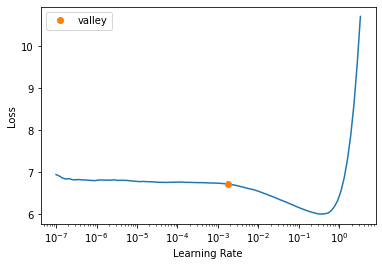

In [16]:
torch.cuda.empty_cache()
parent_lm_fns = [path/"models"/lmf for lmf in lm_fns]
learn_lm = language_model_learner(dls_lm, AWD_LSTM, pretrained_fnames=parent_lm_fns, metrics=accuracy,
                                  config={**awd_lstm_lm_config, "n_hid": 1152}, drop_mult=1.0)
learn_lm.lr_find()

In [17]:
lr = 1e-3
lr *= bs/48

learn_lm.fit_one_cycle(2, lr*10)

epoch,train_loss,valid_loss,accuracy,time
0,4.734736,4.040380,0.324243,00:08
1,4.282218,3.921920,0.336190,00:08


In [18]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.006910,3.826614,0.346760,00:08
1,3.899430,3.704142,0.359175,00:08
2,3.776097,3.625240,0.367463,00:09
3,3.670741,3.580811,0.371431,00:09
4,3.593476,3.550883,0.375172,00:08
5,3.542312,3.536903,0.376332,00:08
6,3.493093,3.531152,0.377729,00:08
7,3.479572,3.529681,0.377607,00:09


In [19]:
learn_lm.save(mdl_path/f"{lang}fine_tuned_bwd")
learn_lm.save_encoder(mdl_path/f"{lang}fine_tuned_enc_bwd")

# Classifier

In [20]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_df("comment", vocab=dls_lm.vocab, backwards=True), CategoryBlock),
    get_x=ColReader("text"), get_y=ColReader("label"), 
    splitter=RandomSplitter(0.1)
).dataloaders(df, bs=bs, num_workers=os.cpu_count(), backwards=True)
dls_clas.show_batch(max_n=2)

,text,category
0,". đáng xứng khen lời những nhận để đủ cũng vậy như niên thiếu cho dành phẩm tác một với đối nhưng xxmaj \n . nhiều gì lại đọng không , tuột xxunk trôi thế cứ truyện dung nội lại sách cuốn gấp , ngẫm suy phải đọc người được bắt không truyện , là hai thứ xxmaj \n . sắc sâu tượng ấn tạo không , nhạt nhàn cứ vật nhân các giác cảm nên , thân bản lộ xxunk tự vật nhân để là hơn nhiều lể kể về thiên vật nhân dựng xây , là nhất thứ xxmaj \n . này sách cuốn về lòng hài chưa tôi khiến điểm hai có xxup \n\n ? người con vệ bảo việc trong lùi bước hay tiến bước là đó , hỏi tự tôi và xxup … cãi bàn không , vậy như xử cư phải người con yếu",1
1,"? lậu bản đọc đang mình hay xxmaj ? nào tí tâm có chả sách làm ông mấy thấy mình làm cũng thôi nhiêu bấy nhưng xong đọc chưa mình xxmaj . cười buồn rất đọc . "" "" trẻ ở tinh động hoạt "" "" . em trẻ với liền đi này từ cụm là cái le éo mà xxup ? xxunk tờ tinh hay rùng tờ tinh xxmaj ? không gì là tinh động hoạt hiểu có bạn các xxmaj . ) ấy sách trong đầu trang chục vài ở nằm ( "" "" tinh động hoạt "" "" "" "" tinh động hoạt "" "" : luôn nghĩa ý được hiểu không mình chắc đời suốt là thề mà từ cụm 1 nhớ mình xxmaj . ngầu xà loạn viết giả tác ông do hay kém dịch do này cái rõ không xxmaj . ) cả gì",1


In [21]:
from sklearn.metrics import f1_score

@np_func
def f1(inp, targ): return f1_score(targ, np.argmax(inp, axis=-1))

Actually, we already have `f1_score` from fastai v2, however we will just use our own function to compare with v1 availability. 

/home/wabinab/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=tensor(0.0021))

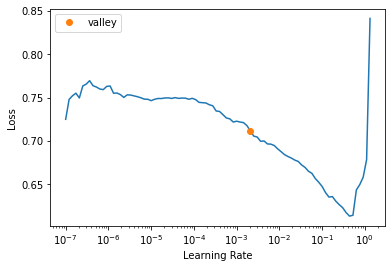

In [23]:
# metrics = [accuracy, f1_score]  # for using internal f1_score. 
learn_c = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                metrics=[accuracy, f1]).to_fp16()
learn_c.load_encoder(mdl_path/f"{lang}fine_tuned_enc_bwd")
learn_c.freeze()
learn_c.lr_find()

In [24]:
lr = 2e-2
lr *= bs/48

learn_c.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.436744,0.382030,0.764597,0.603090,00:06
1,0.420229,0.379550,0.770880,0.518112,00:06


In [25]:
learn_c.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.425414,0.376272,0.776423,0.525850,00:08
1,0.418404,0.374201,0.775314,0.503831,00:11


In [26]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4), lr))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.410345,0.367340,0.773836,0.589374,00:12
1,0.393534,0.381253,0.779749,0.570039,00:12


In [27]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4), lr/2))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.389544,0.363741,0.773836,0.590586,00:15
1,0.376116,0.355826,0.783075,0.592611,00:14


In [28]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4), lr/10))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.342563,0.380948,0.782336,0.594261,00:16


In [30]:
learn_c.save(mdl_path/f"{lang}clas_bwd")

Path('/home/wabinab/.fastai/viwiki/models/viclas_bwd.pth')

In [33]:
save_pickle(mdl_path/f"{lang}_vocab_bwd.pkl", dls_lm.vocab)